-------------------------------------------------------
- Wiley Winters
- MSDS 686 Deep Learning
- Week 7-8 Kaggle Project&nbsp;&mdash;&nbsp;Brain Tumor Classification
- 2025-MAR-
--------------------------------------------------------

## Requirements

----------------------------------------------
### Required for 80%
Complete project on *kaggle.com* using the skills learned in the <u>Deep Learning</u> class.  The following are required:
- Show/plot sample images or data with labels
- Include at least on of the following
  - Convolution
  - Max Pooling
  - Batch Normalization
  - Dropout
  - LSTM
  - TF-IDf
- Use validation data
- Evaluate model on test data

-------------------------------------------
### Additional for another 20%
- Use data augmentation
- Use at least one of the following:
  - Kernels
  - Activation functions
  - Loss functions
  - Libraries
  - Methods
- Learning rate optimization
- Functional API model
- Transfer learning with or without trainable parameters
- Confusion matrix and / or ROC plots
- Plots of accuracy/loss vs epochs
- Show/plot sample incorrect prediction with labels and correct label

----------------------------------------------------------------
## Load Libraries and Packages

In [1]:
# General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, logging, random

# Data prep and model scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

# TensorFlow likes to display a lot of debug information
# on my home system
# I will squash the messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorFlow').setLevel(logging.FATAL)

# tensorflow and keras' API
import tensorflow as tf
from tensorflow import keras

# Model building
from keras.applications import Xception
from tensorflow.keras import backend
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model architecture visualization
from visualkeras import layered_view

# Model training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

# Make plots have guidelines
plt.style.use('ggplot')

# Squash Python warnings
import warnings
warnings.filterwarnings('ignore')

E0000 00:00:1740655572.541027  445062 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740655572.546520  445062 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Set Random Seed for Reproducibility

In [2]:
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Declare Global Variables

In [3]:
# Define training and testing image directories
home_dir = '/home/wiley'
trn_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/training'
tst_dir = home_dir+'/regis/dataScience/kaggleProject/images/data/testing'

#home_dir = '/disk01/e384698'
#trn_dir = home_dir+'/msds686/week7/images/data/training/'
#tst_dir = home_dir+'/msds686/week7/images/data/testing/'

# Define classes
classes = ['negative', 'positive']

# Define early_stop callback
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=8,
                           restore_best_weights=True)

# Define reduce LR on Plateau callback
reduceLRO = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5,
                              min_delta=0.0001, min_lr=0,
                              restore_best_weights=True)

# Image size and shape
img_size = (224, 224)
img_shape = (224, 224, 3)

# Number of classes
num_classes = 2

## Define Functions

### Load DataFrames
- Join image filename and path information
- Create labels from class directory names
- Create dataframe
- Randomize dataframe rows

In [4]:
def load_dataframe(path):
    labels, paths = zip(*[(label, os.path.join(path, label, image))
                        for label in os.listdir(path)
                        if os.path.isdir(os.path.join(path, label))
                        for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'paths': paths, 'labels': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

### Plot Performance Metrics
Plot the following:
- Training loss
- Validation loss
- Training Precision
- Validation Precision
- Training Recall
- Validation Recall

In [5]:
def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(20,12))

    # Plot training and validation loss
    plt.subplot(2,2,1)
    plt.plot(epochs, history.history['loss'], 'b', label = 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2,2,2)
    plt.plot(epochs, history.history['accuracy'], 'b', label = 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation precision
    plt.subplot(2,2,3)
    plt.plot(epochs, history.history['precision'], 'b', label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot training and validation recall
    plt.subplot(2,2,4)
    plt.plot(epochs, history.history['recall'], 'b', label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.suptitle('Model Training Metrics over Epochs', fontsize=16)
    plt.show()

    # Plot training and validation AUPRC
    plt.figure(figsize=(5,3))
    plt.plot(epochs, history.history['auprc'], 'b', label='Training AUPRC')
    plt.plot(epochs, history.history['val_auprc'], 'r', label='Validation AUPRC')
    plt.title('Training and Validation AUPRC')
    plt.xlabel('Epochs')
    plt.ylabel('AUPRC')
    plt.legend()
    plt.show()

### Evaluate Model's Performance on Test Data
- Compute accuracy and loss
- Compute AUPRC (**A**rea **U**under the **P**recision&nbsp;&mdash;&nbsp;**R**ecall score)
- Compute ROC AUC Scores

In [6]:
def score_model(model, trn_ds, tst_ds):
    my_model = model
    prediction = my_model.predict(tst_ds)
    train_score = my_model.score(trn_ds)
    accur_score = accuracy_score(tst_ds, prediction)
    f1 = f1_score(tst_ds, prediction)
    roc_score = roc_auc_score(tst_ds, prediction)
    cm = confusion_matrix(tst_ds, prediction).flatten()
    
    print(f'Model:          {my_model}')
    print(f'Train Score:    {train_score}')
    print(f'Accuracy Score: {accur_score}')
    print(f'F1 score:       {f1}')
    print(f'ROC AUC Score:  {roc_score}')
    print(f'Confusion:      {cm}')
    
    return prediction

## Load Data

### Create and Load DataFrame for EDA

In [7]:
# Load training data
trn_df = load_dataframe(trn_dir)

# Load testing data
tst_df = load_dataframe(tst_dir)

# Take a look at the results
print('Training:   \n', trn_df.head(10).to_markdown())
print('Testing:    \n', tst_df.head(10).to_markdown())

Training:   
 |    | paths                                                                                                   | labels   |
|---:|:--------------------------------------------------------------------------------------------------------|:---------|
|  0 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/TCGA_HT_7881_19981015_39.tif  | positive |
|  1 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Te-me_0244.jpg                | negative |
|  2 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/positive/TCGA_DU_8167_19970402_19.tif  | positive |
|  3 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Tr-no_1073.jpg                | negative |
|  4 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Tr-no_0417.jpg                | negative |
|  5 | /home/wiley/regis/dataScience/kaggleProject/images/data/training/negative/Tr-pi_0984.jpg                | negat

## EDA

### Look at Training Images' Distribution

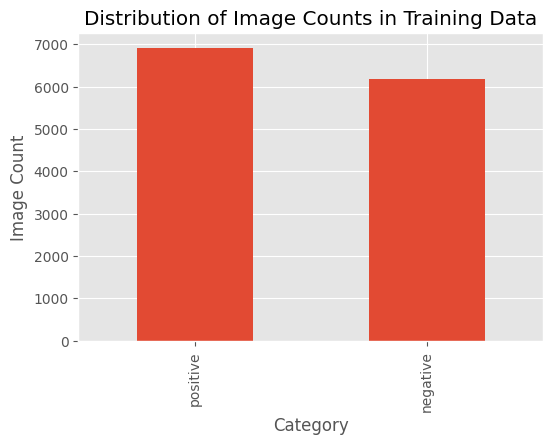

In [8]:
plt.figure(figsize=(6,4))
trn_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Training Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

Positive images slightly outnumber the negative ones, but are close enough to continue without additional data wrangling

### Look at Testing Images' Distribution

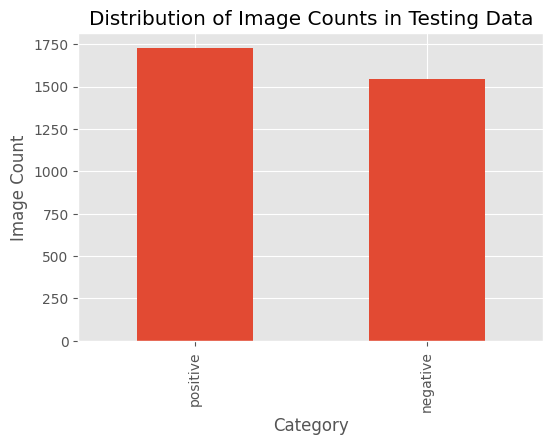

In [9]:
plt.figure(figsize=(6,4))
tst_df['labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Image Counts in Testing Data')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()

Distribution mirrors what the *training data* shows, but with less frequency.

### Examine Shape of Training and Testing DataFrames

In [10]:
print('Training Shape: \n', trn_df.shape)
print('Testing Shape:  \n', tst_df.shape)

Training Shape: 
 (13106, 2)
Testing Shape:  
 (3276, 2)


**NOTE:**&nbsp;&nbsp;Since the dataframes are built from the contents of the image directories, there should be no missing values or duplicates.

## Data Wrangling

### Create a Validation Subset from Training Data
I will use `flow_from_dataframe()` to create datasets for model training; therefore, no reason to create a new directory structure for validation data

In [11]:
val_df, trn_df = train_test_split(trn_df, train_size=0.2, random_state=42,
                                  stratify=trn_df['labels'])
val_df.sample(10)

,paths,labels
4171,/home/wiley/regis/dataScience/kaggleProject/im...,positive
11066,/home/wiley/regis/dataScience/kaggleProject/im...,positive
6446,/home/wiley/regis/dataScience/kaggleProject/im...,positive
10366,/home/wiley/regis/dataScience/kaggleProject/im...,positive
10099,/home/wiley/regis/dataScience/kaggleProject/im...,positive
4255,/home/wiley/regis/dataScience/kaggleProject/im...,positive
6141,/home/wiley/regis/dataScience/kaggleProject/im...,positive
381,/home/wiley/regis/dataScience/kaggleProject/im...,positive
1675,/home/wiley/regis/dataScience/kaggleProject/im...,negative
12140,/home/wiley/regis/dataScience/kaggleProject/im...,positive


## Process Images from DataFrames

In [12]:
bs = 32

gen = ImageDataGenerator(brightness_range=(0.5, 1.5),
                         rotation_range=20,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2)

tst_gen = ImageDataGenerator(rescale=1./255)

trn_gen = gen.flow_from_dataframe(trn_df, x_col='paths', y_col='labels',
                                  batch_size=bs, target_size=img_size,
                                  shuffle=True)

val_gen = gen.flow_from_dataframe(val_df, x_col='paths', y_col='labels',
                                  batch_size=bs, target_size=img_size,
                                  shuffle=True)

tst_gen = tst_gen.flow_from_dataframe(tst_df, x_col='paths', y_col='labels',
                                      batch_size=16, target_size=img_size,
                                      shuffle=False)

Found 10485 validated image filenames belonging to 2 classes.
Found 2621 validated image filenames belonging to 2 classes.
Found 3276 validated image filenames belonging to 2 classes.


## Examine a few Images and their Labels

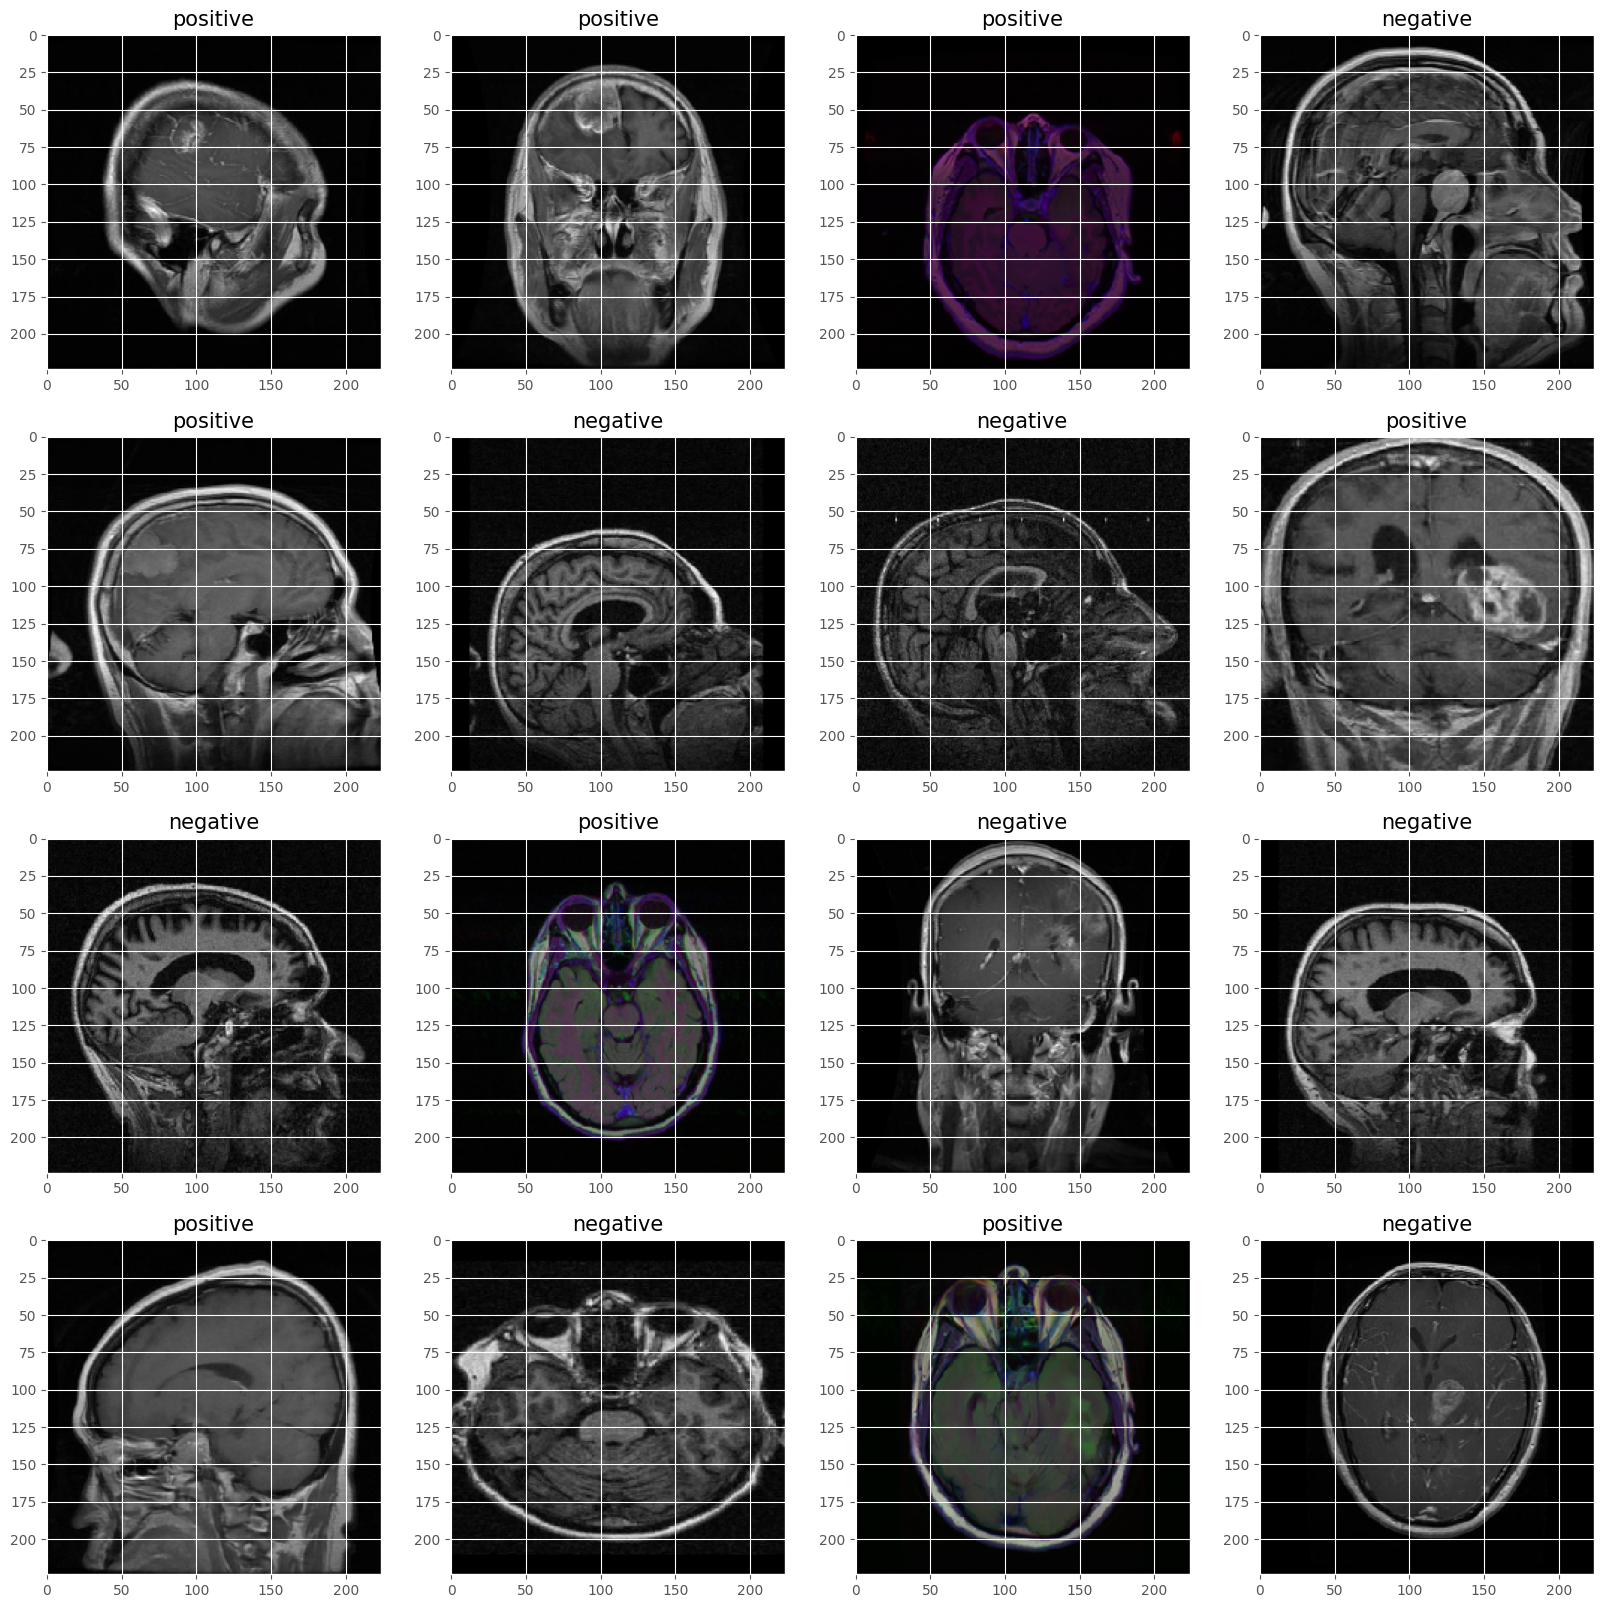

In [13]:
dict = trn_gen.class_indices
classes = list(dict.keys())
images, labels = next(tst_gen)

plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

### Configure Training Values

In [14]:
# Initial batch size
batch_size = 64

# Number of training epochs
epochs = 50

# Steps per epoch
steps_per_ep = trn_gen.samples // batch_size

# Validation steps
val_steps = tst_gen.samples // batch_size

print(f'Image shape:      {img_shape}')
print(f'Epochs:           {epochs}')
print(f'Batch size:       {batch_size}')
print(f'Steps per epoch:  {steps_per_ep}')
print(f'Validation steps: {val_steps}')

Image shape:      (224, 224, 3)
Epochs:           50
Batch size:       64
Steps per epoch:  163
Validation steps: 51


## Baseline Model
### Define Model's Architecture

In [15]:
backend.clear_session()

inputs  = Input(shape=(img_shape))

# Conv Layer 1
conv1   = Conv2D(filters=32, kernel_size=4, padding='same',
                 activation='relu')(inputs)
pool1   = MaxPooling2D()(conv1)

# Conv Layer 2
conv2   = Conv2D(filters=64, kernel_size=4, padding='same',
                 activation='relu')(pool1)
pool2   = MaxPooling2D()(conv2)

# Conv Layer 3
conv3   = Conv2D(filters=128, kernel_size=4, padding='same',
                 activation='relu')(pool2)
pool3   = MaxPooling2D()(conv3)

# Apply Batch Normalization, Flatten, and Dense Layers
batch3  = BatchNormalization()(pool3)
flatten = Flatten()(batch3)
dense1   = Dense(128, activation='relu')(flatten)
dropout = Dropout(0,5)(dense1)
dense2   = Dense(512, activation='relu')(dropout)

# Pull the model together
preds   = Dense(num_classes, activation='softmax')(dense1)

model_base = Model(inputs, preds)

model_base.summary()

I0000 00:00:1740655619.763156  445062 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:09:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,011,554 (49.64 MB)

 Trainable params: 13,011,298 (49.63 MB)

 Non-trainable params: 256 (1.00 KB)

### Visualize Layers

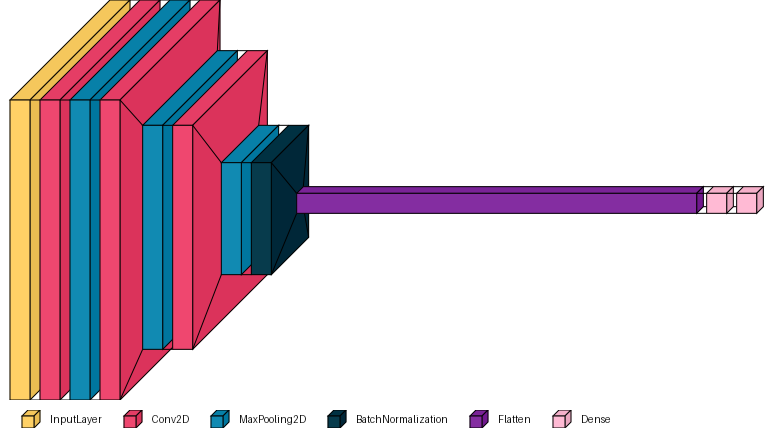

In [16]:
layered_view(model_base, legend=True, max_xy=300)

### Compile and Train Model

In [17]:
# Compile base model
model_base.compile(optimizer='Adam', loss='categorical_crossentropy',
                   metrics=['accuracy', Precision(), Recall(),
                            tf.keras.metrics.AUC(curve='PR', name='auprc')])

hist_base = model_base.fit(trn_gen, steps_per_epoch=steps_per_ep, epochs=epochs,
                           validation_data=val_gen,
                           validation_steps=val_steps,
                           callbacks=[early_stop, reduceLRO])

Epoch 1/50


I0000 00:00:1740655631.341982  445211 service.cc:148] XLA service 0x7f9e1400eb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740655631.342006  445211 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1740655631.624433  445211 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5625 - auprc: 0.5486 - loss: 7.6310 - precision: 0.5625 - recall: 0.5625 

I0000 00:00:1740655636.222761  445211 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 435ms/step - accuracy: 0.6533 - auprc: 0.6928 - loss: 2.5261 - precision: 0.6533 - recall: 0.6533 - val_accuracy: 0.7096 - val_auprc: 0.7466 - val_loss: 1.3937 - val_precision: 0.7096 - val_recall: 0.7096 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.7357 - auprc: 0.8418 - loss: 0.4975 - precision: 0.7357 - recall: 0.7357 - val_accuracy: 0.7503 - val_auprc: 0.8297 - val_loss: 0.7508 - val_precision: 0.7503 - val_recall: 0.7503 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.8276 - auprc: 0.8932 - loss: 0.4175 - precision: 0.8276 - recall: 0.8276 - val_accuracy: 0.7365 - val_auprc: 0.8399 - val_loss: 0.6102 - val_precision: 0.7365 - val_recall: 0.7365 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.7622 - auprc: 0.8614 - loss: 0.5075 - precision: 0.7622 - recall: 0.7622 - val_accuracy: 0.6633 - val_auprc: 0.7530 - val_lo

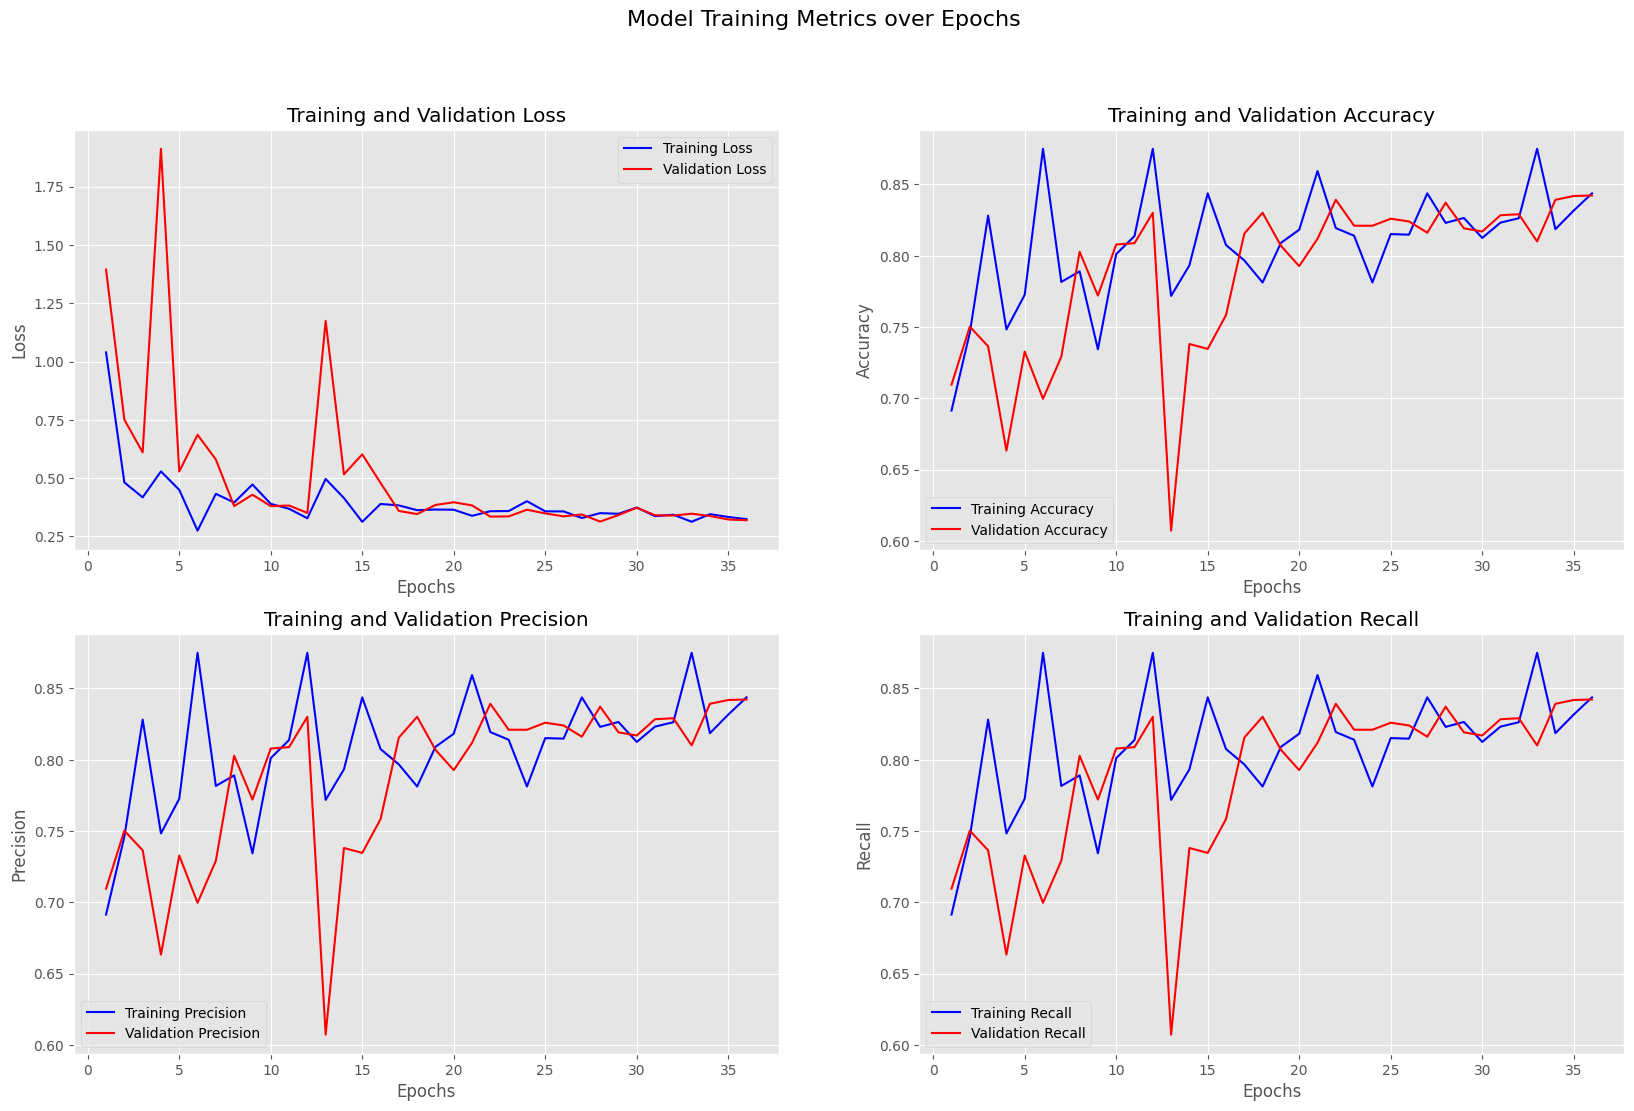

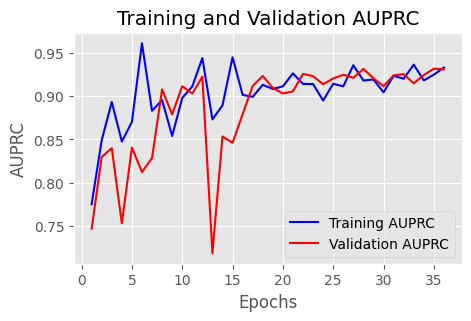

In [18]:
plot_history(hist_base)

In [ ]:
hist_df = pd.DataFrame(hist_base.history)
hist_df.tail()

In [ ]:
model_base.evaluate(tst_gen, verbose=1)

In [ ]:
# Get predictions
trn_pred = np.argmax(np.round(model_base.predict(trn_gen)), axis=1)
tst_pred = np.argmax(np.round(model_base.predict(tst_gen)), axis=1)

# Produce confusion matrix
trn_cm = confusion_matrix(trn_gen.classes, trn_pred)
tst_cm = confusion_matrix(tst_gen.classes, tst_pred)

print(f'Training Confusion Matrix:\n {trn_cm}')
print(f'Testing Confusion Matrix:\n {tst_cm}')